In [133]:
#Importing the necessary libraries we will be using
%load_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.tabular.core import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

#Loading the Dataset
from sklearn.model_selection import train_test_split
df_raw = pd.read_csv(f'./housing.csv',low_memory = False)
df_raw_train, df_raw_test=train_test_split(df_raw,test_size=0.196,shuffle=True,random_state=1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
df_raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406 entries, 426 to 37
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       406 non-null    int64  
 1   CRIM     406 non-null    float64
 2   ZN       406 non-null    float64
 3   INDUS    406 non-null    float64
 4   CHAS     406 non-null    int64  
 5   NOX      406 non-null    float64
 6   RM       406 non-null    float64
 7   AGE      406 non-null    float64
 8   DIS      406 non-null    float64
 9   RAD      406 non-null    int64  
 10  TAX      406 non-null    int64  
 11  PTRATIO  406 non-null    float64
 12  BLACK    406 non-null    float64
 13  LSTAT    406 non-null    float64
 14  MEDV     406 non-null    float64
dtypes: float64(11), int64(4)
memory usage: 50.8 KB


/Users/fernandez48/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='MEDV', ylabel='Density'>

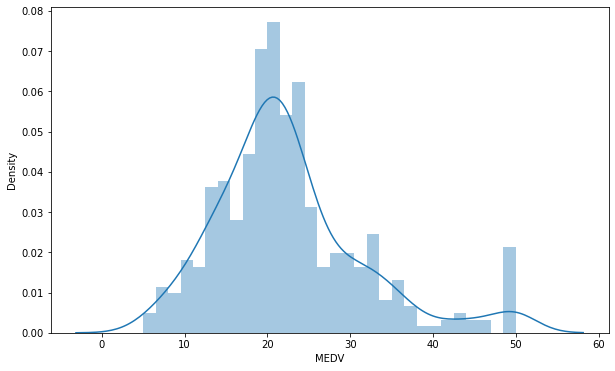

In [135]:
#Plot the distribution of MEDVplt.figure(figsize=(10, 6))
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.distplot(df_raw_train['MEDV'],bins=30)

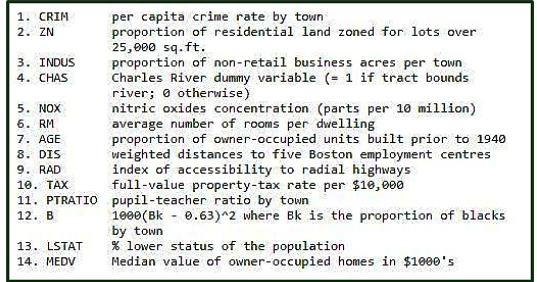

In [136]:
from PIL import Image
Image.open('./labels.png')

<AxesSubplot:>

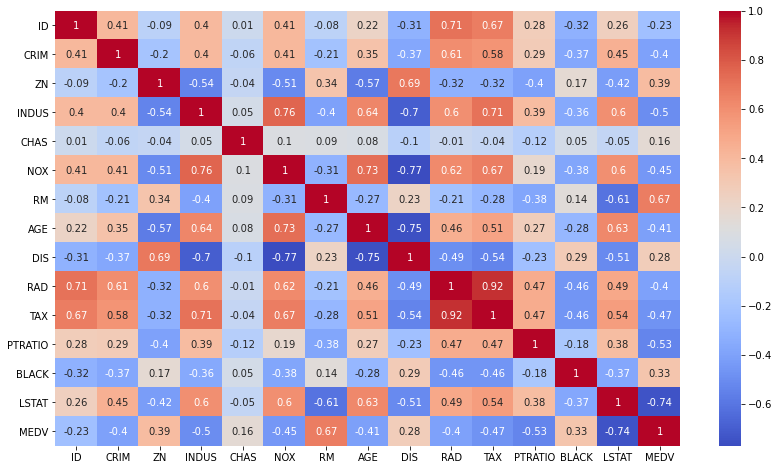

In [137]:
# Plot the correlation heatmap
plt.figure(figsize=(14, 8))
corr_matrix = df_raw_train.corr().round(2)
sns.heatmap(data=corr_matrix,cmap='coolwarm',annot=True)

In [138]:
# A function to split our training data into a training set to train our  model and a validations set, which will be used to validate our model.
def split_vals(a,n):
    return a[:n],a[n:]# Functions that will help us calculate the RMSE and print the score.
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res =[rmse(m.predict(X_train),y_train),rmse(m.predict(X_valid),y_valid),m.score(X_train,y_train),m.score(X_valid,y_valid)]
    if hasattr(m,'oob_score_'):res.append(m.oob_score_)
    print(res)

n_valid = 100
n_train = len(df_raw_train)-n_valid
X_train,X_valid = split_vals(df_raw_train.drop('MEDV',axis=1),n_train)
y_train,y_valid = split_vals(df_raw_train['MEDV'],n_train)
X_test = df_raw_test


RF_model=RandomForestRegressor(n_jobs=4,oob_score=True)
RF_model.fit(X_train,y_train)
print_score(RF_model)

#Feature tunning

def feat_importance(RF_model,df_train):
    importance = RF_model.feature_importances_
    importance = pd.DataFrame(importance,index=df_train.columns,columns=["Importance"])
    return importance.sort_values(by=['Importance'],ascending=False)

importance = feat_importance(RF_model,X_train)
importance[:]

[1.3883486617330483, 3.0479907873876515, 0.9755291994186666, 0.8930979485836483, 0.8190100025368028]


,Importance
LSTAT,0.541004
RM,0.236221
CRIM,0.057064
DIS,0.045894
NOX,0.026336
ID,0.016953
PTRATIO,0.016392
AGE,0.015154
BLACK,0.014632
TAX,0.012430


<AxesSubplot:>

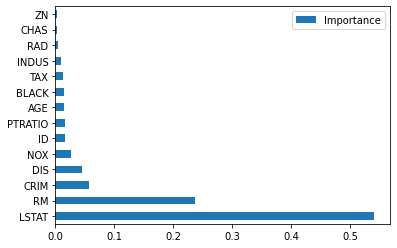

In [139]:
importance.plot(kind='barh')

In [140]:
#Discarding features with feature coefficients less than 0.01
to_keep = importance[importance['Importance'] > 0.01].index
df_raw_train_keep = df_raw_train[to_keep].copy()
df_raw_test_keep = df_raw_test[to_keep].copy()#Splitting data into training and validation set
X_train,X_valid = split_vals(df_raw_train_keep,n_train)
# Fitting our Random Forest Model after discarding the less important features.

In [141]:
RF_model=RandomForestRegressor(n_jobs=4,oob_score=True)
RF_model.fit(X_train,y_train)
print_score(RF_model)

[1.376961123140564, 3.0831419542408343, 0.9759289828010952, 0.8906180198289155, 0.8321170434954299]


In [142]:
def feat_importance(m,df_raw_train_keep):
    importance = m.feature_importances_
    importance = pd.DataFrame(importance,index=df_train.columns,columns=["Importance"])
    return importance.sort_values(by=['Importance'],ascending=False)

importance

,Importance
LSTAT,0.541004
RM,0.236221
CRIM,0.057064
DIS,0.045894
NOX,0.026336
ID,0.016953
PTRATIO,0.016392
AGE,0.015154
BLACK,0.014632
TAX,0.012430


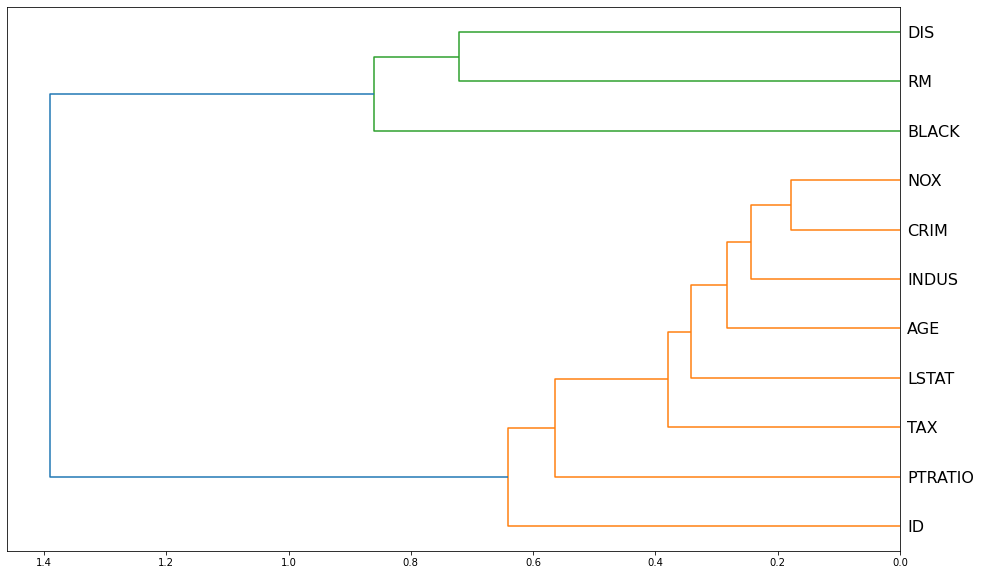

In [143]:
#Dendogram plotfrom scipy.cluster 

from scipy.cluster.hierarchy import dendrogram, linkage

corr = np.round(scipy.stats.spearmanr(df_raw_train_keep).correlation,4)
corr_condensed = scipy.spatial.distance.squareform(1-corr)
z = linkage(corr_condensed,method='average')
fig = plt.figure(figsize=(16,10))
dendogram = dendrogram(z,labels=df_raw_train_keep.columns,orientation='left',leaf_font_size=16)
plt.show()

In [144]:
#Grid search

n_estimators = [int(x) for x in np.arange(start = 10, stop = 2000, step = 10)]
max_features = [0.5,'auto', 'sqrt','log2']
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# First create the base model to tune
RF_model = RandomForestRegressor()
# Fit the random search model
RF_model_random = RandomizedSearchCV(estimator = RF_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
RF_model_random.fit(X_train, y_train)
RF_model_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1010,
 'min_samples_leaf': 1,
 'max_features': 0.5,
 'bootstrap': False}

In [146]:
df_sub=df_raw_train_keep.drop(['AGE','BLACK','ID','TAX'],axis=1)
print(df_sub)
df_sub=df_raw_train_keep
X_train,X_valid=split_vals(df_sub,n_train)
RF_model=RandomForestRegressor(n_estimators=840,min_samples_leaf=1,max_features=0.5,bootstrap=False,n_jobs=4,random_state=1)
RF_model.fit(X_train,y_train)
print_score(RF_model)

     LSTAT     RM      CRIM     DIS    NOX  PTRATIO  INDUS
426  15.69  5.837  12.24720  1.9976  0.584     20.2  18.10
443  18.85  6.485   9.96654  1.9784  0.740     20.2  18.10
42    5.81  6.169   0.14150  5.7209  0.448     17.9   6.91
58    6.86  6.145   0.15445  7.8148  0.453     19.7   5.13
385  30.81  5.277  16.81180  1.4261  0.700     20.2  18.10
..     ...    ...       ...     ...    ...      ...    ...
255   9.25  5.876   0.03548  9.2203  0.392     16.4   3.64
72    5.52  6.065   0.09164  5.2873  0.413     19.2  10.81
396  19.37  6.405   5.87205  1.6768  0.693     20.2  18.10
235  10.88  6.086   0.33045  3.6519  0.507     17.4   6.20
37    8.77  5.850   0.08014  3.9342  0.499     19.2   5.96

[406 rows x 7 columns]
[4.812214782705659e-05, 2.650076918727096, 0.9999999999706004, 0.9191880291771285]


RMSE: 2.650077


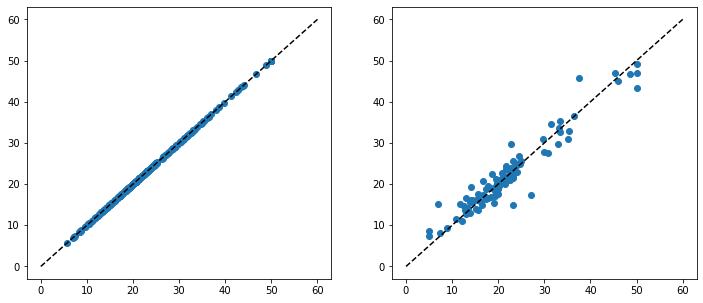

In [147]:
preds = RF_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
print("RMSE: %f" % (rmse))

ub=60
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_train,RF_model.predict(X_train))
plt.plot([0,ub],[0,ub],'k--')
plt.subplot(1,2,2)
plt.scatter(y_valid,RF_model.predict(X_valid))
plt.plot([0,ub],[0,ub],'k--')

In [70]:
##XGBoost

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
data = pd.read_csv(f'./housing.csv',low_memory = False)
X, y = data.iloc[:,:-1],data.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.196,shuffle=True,random_state=1)


RMSE: 10.625356


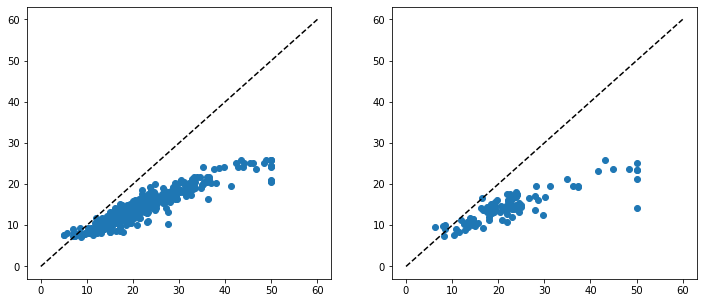

In [71]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 10)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

ub=60
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_train,xg_reg.predict(X_train))
plt.plot([0,ub],[0,ub],'k--')
plt.subplot(1,2,2)
plt.scatter(y_test,xg_reg.predict(X_test))
plt.plot([0,ub],[0,ub],'k--')

In [72]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=100,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

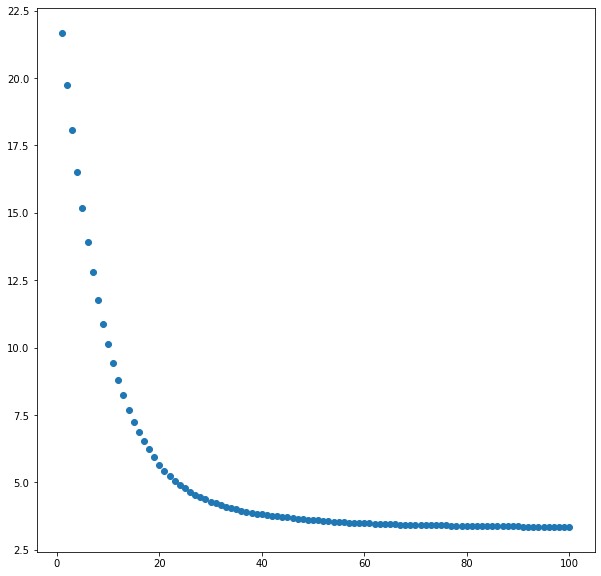

In [73]:
plt.scatter(np.linspace(1,len(cv_results),len(cv_results)),cv_results.iloc[:,2])

In [74]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.651110,0.031209,21.672590,0.059100
1,19.692797,0.008399,19.749607,0.048989
2,17.971043,0.027892,18.073188,0.034702
3,16.375992,0.089105,16.523335,0.037585
4,14.968928,0.054016,15.178753,0.030626


In [75]:
print((cv_results["test-rmse-mean"]).tail(1))

99    3.340536
Name: test-rmse-mean, dtype: float64


In [76]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

<Figure size 4320x2160 with 0 Axes>

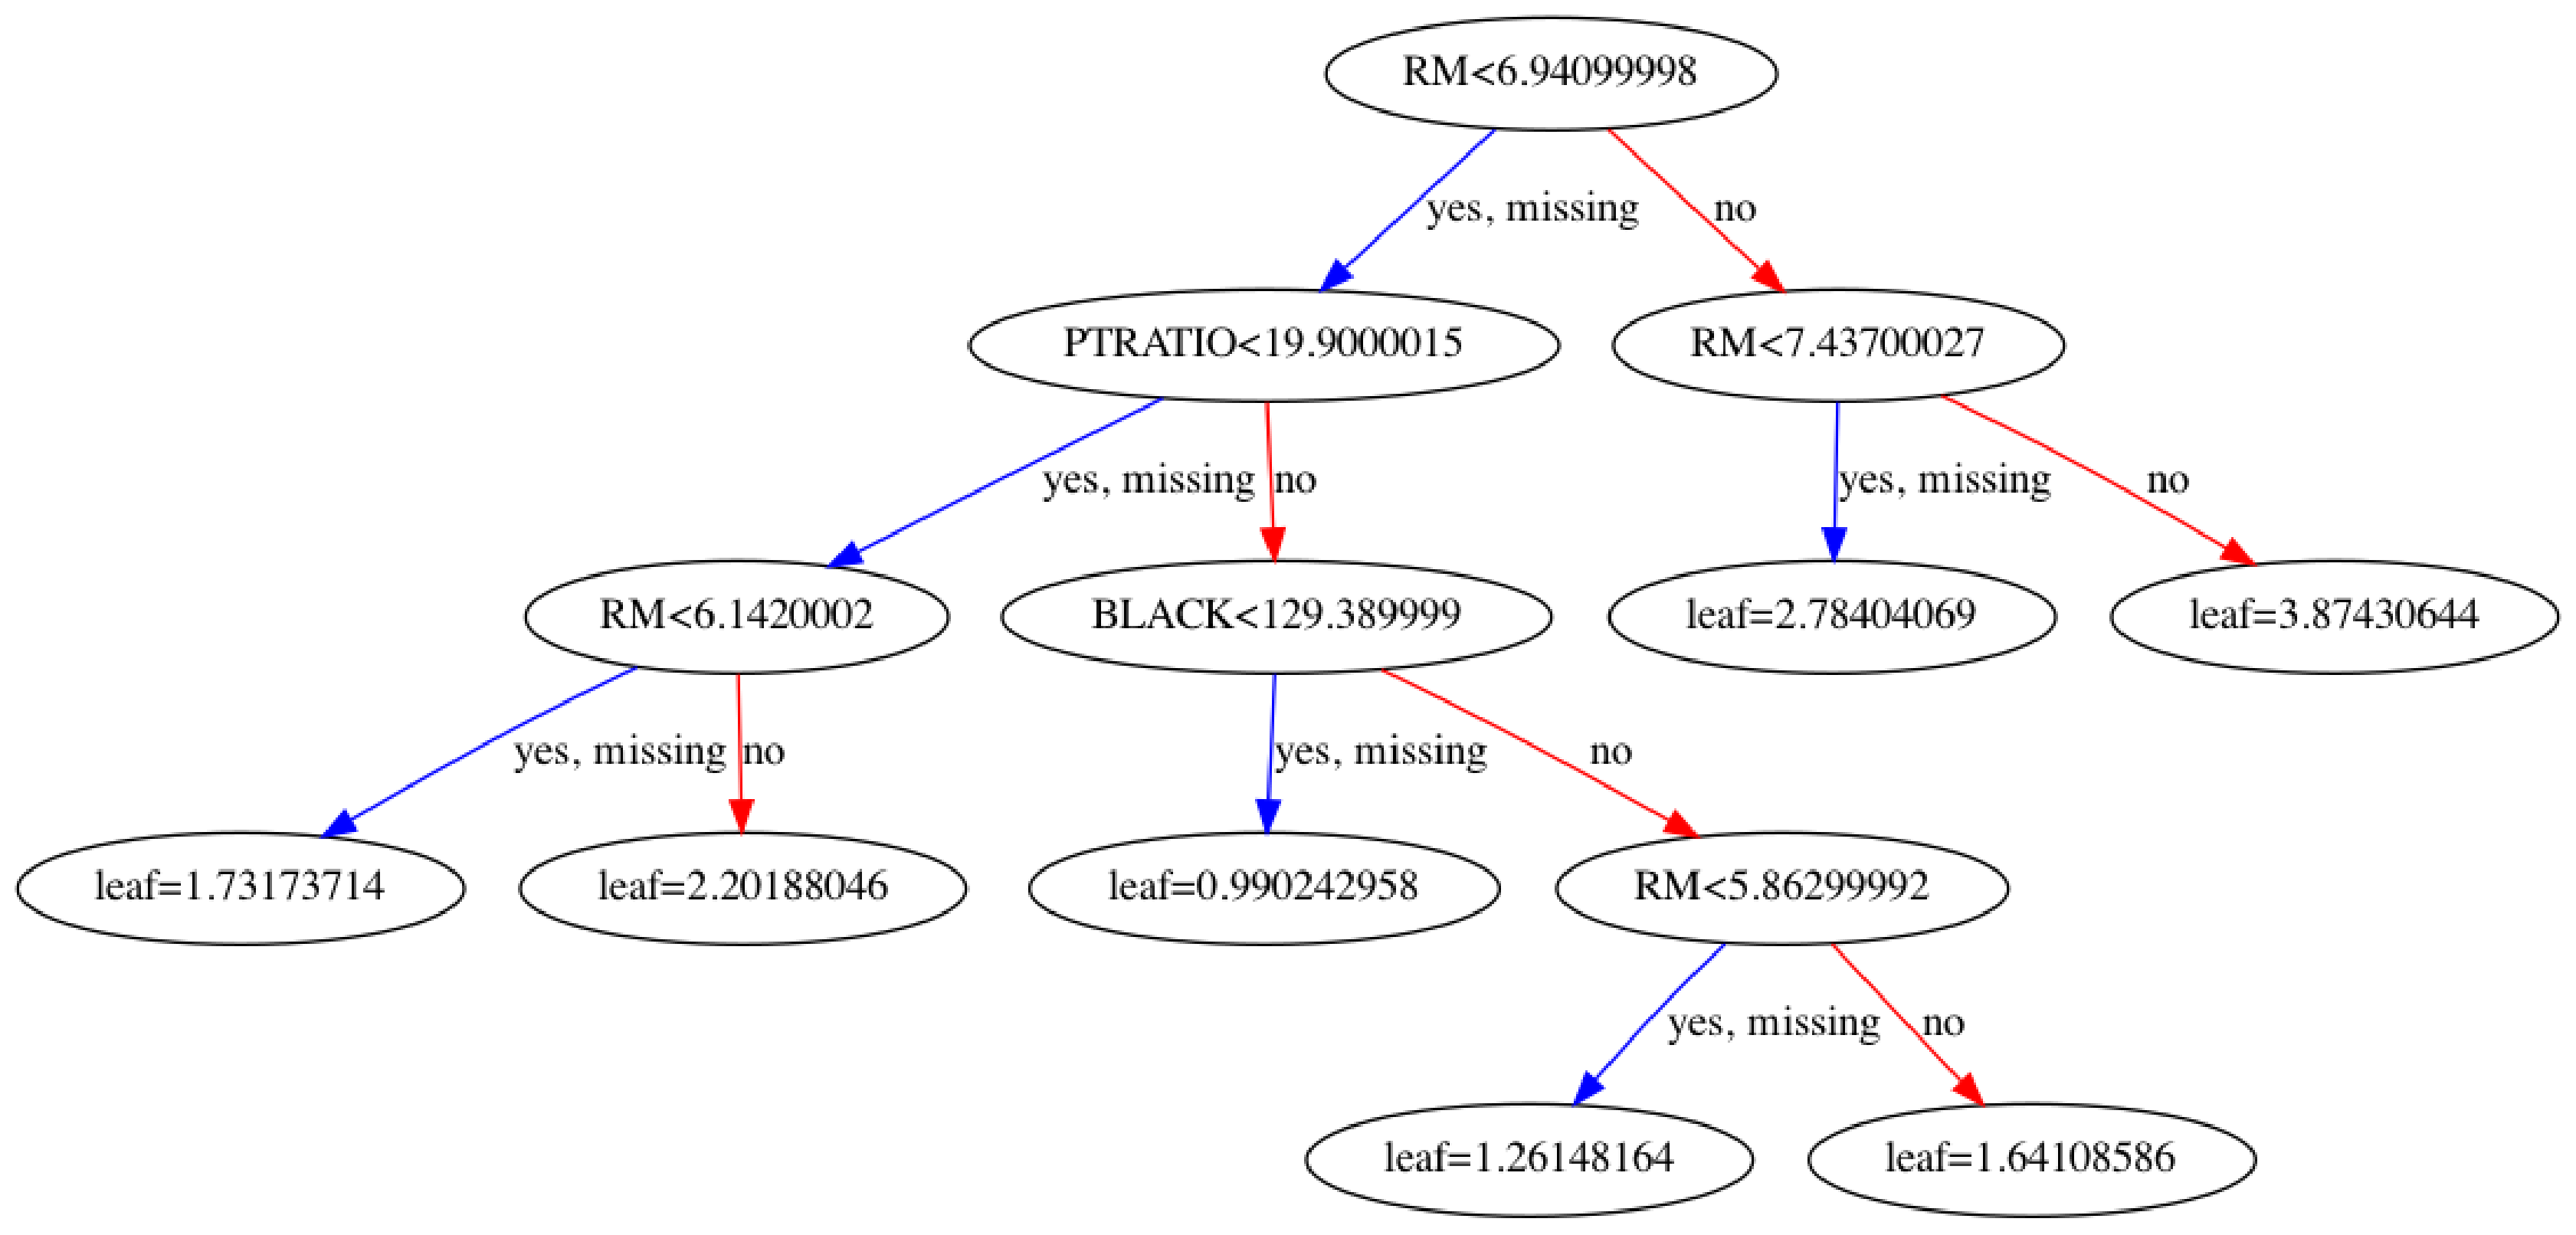

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=[60,30])
xgb.plot_tree(xg_reg,num_trees=1)
plt.rcParams['figure.figsize'] = [60, 30]
plt.show()



<Figure size 720x720 with 0 Axes>

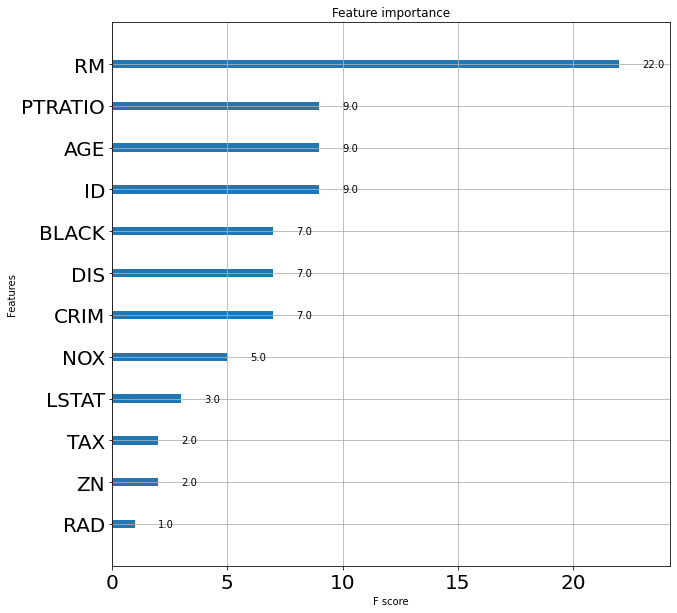

In [80]:
plt.figure()
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


In [128]:
from sklearn.model_selection import train_test_split
data = pd.read_csv(f'./housing.csv',low_memory = False)

#data=data.drop(['RAD','ZN','LSTAT','NOX','CRIM','AGE','BLACK','ID','TAX'],axis=1)
X, y = data.iloc[:,:-1],data.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.196,shuffle=True,random_state=1)




In [129]:
#Grid search



n_estimators = [int(x) for x in np.arange(start = 20, stop = 90, step = 10)]
max_depth = [50,100,150,200]
alpha = [2, 4, 6, 10]
learning_rate = [0.01, 0.1, 1, 5]
colsample_bytree = [0.3,0.5,1,5,10]
booster = ['gbtree', 'gblinear','dart']
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'alpha': alpha,
               'learning_rate': learning_rate,
              'colsample_bytree' : colsample_bytree,
              'booster':booster}

# First create the base model to tune
XGB_model = xgb.XGBRegressor()
# Fit the random search model
XGB_model_random = RandomizedSearchCV(estimator = XGB_model, param_distributions = random_grid, verbose=2, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
XGB_model_random.fit(X_train, y_train)
XGB_model_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/fernandez48/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [ 7.46608670e-01  7.21700903e-01             nan  7.93985550e-01
             nan  5.44170392e-01             nan             nan
  7.37613915e-01  5.20179553e-01             nan  8.36182956e-01
             nan             nan  7.53528363e-01             nan
 -4.57667954e+60             nan             nan -1.02929057e-01
 -5.08760319e-02  7.46608670e-01             nan  7.21700903e-01
 -4.28085044e-01  6.57608249e-01             nan             nan
 -6.94795118e-01  3.70945078e-01  7.30885803e-01  5.08075031e-01
  7.10816900e-01             nan  5.67763453e-01  8.58592320e-01
  7.95166611e-01             nan  7.30885803e-01             nan
  4.47299756e-01  2.44874264e-02             nan -6.86296685e-02
             nan             nan  5.42906575e-01             nan
  7.21700903e-01  5.20264538e-01 -4.87306571e+24  3.67739398e-0

{'n_estimators': 70,
 'max_depth': 150,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5,
 'booster': 'gbtree',
 'alpha': 6}

RMSE: 2.962122


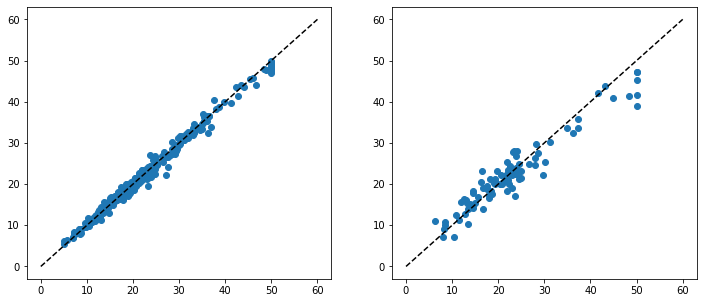

In [132]:
xg_reg = xgb.XGBRegressor(n_estimators = 70,
                          objective ='reg:squarederror', 
                          colsample_bytree = 0.5, 
                          learning_rate = 0.1,
                          max_depth = 150, 
                          alpha = 6, 
                          booster= 'dart',
                          random_state=1
                         )

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

ub=60
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_train,xg_reg.predict(X_train))
plt.plot([0,ub],[0,ub],'k--')
plt.subplot(1,2,2)
plt.scatter(y_test,xg_reg.predict(X_test))
plt.plot([0,ub],[0,ub],'k--')